### E20 Anomaly Detection

- 목표 
    - 시계열 데이터의 이상치의 개념을 이해한다.
    - 다양한 방법으로 이상치를 탐색해본다.
    - 발견한 이상치를 처리하는 방법을 알아본다.

In [46]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from scipy.stats import norm
import numpy as np
from statsmodels.stats.weightstats import ztest
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#### 1. 데이터 불러오기

In [47]:
csv_file = os.getenv('HOME') + '/Aiffel/Exploration/20_anomaly_detection/nasdaq/nasdaq.csv'

df = pd.read_csv(csv_file)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
6166,2020-10-20,11697.500000,11792.000000,11598.5,11660.799805,11660.799805,622702.0
6167,2020-10-21,11675.200195,11779.200195,11585.0,11691.200195,11691.200195,599851.0
6168,2020-10-22,11683.500000,11724.000000,11511.0,11649.799805,11649.799805,583669.0
6169,2020-10-23,11669.200195,11691.799805,11551.0,11663.500000,11663.500000,583669.0
6170,2020-10-25,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6171 entries, 0 to 6170
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6171 non-null   object 
 1   Open       5098 non-null   float64
 2   High       5098 non-null   float64
 3   Low        5098 non-null   float64
 4   Close      5098 non-null   float64
 5   Adj Close  5098 non-null   float64
 6   Volume     5098 non-null   float64
dtypes: float64(6), object(1)
memory usage: 337.6+ KB


In [49]:
df.loc[:, 'Date'] = pd.to_datetime(df.Date)

In [50]:
df.isna().sum()

Date            0
Open         1073
High         1073
Low          1073
Close        1073
Adj Close    1073
Volume       1073
dtype: int64

In [51]:
print(f'삭제 전 데이터 길이 : {len(df)}')
df = df.dropna(axis=0).reset_index(drop=True)

print(f'삭제 후 데이터 길이 : {len(df)}')
df.isna().sum()

삭제 전 데이터 길이 : 6171
삭제 후 데이터 길이 : 5098


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

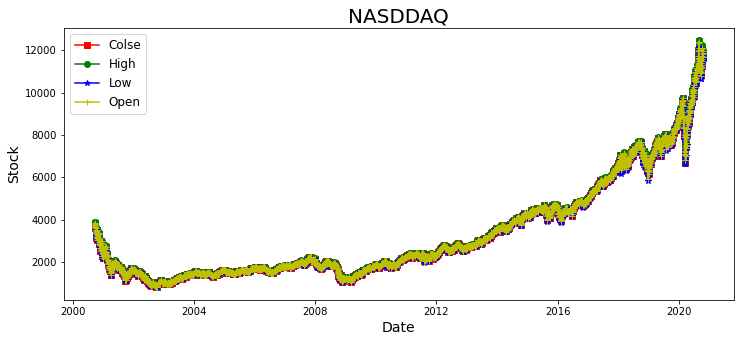

In [52]:
plt.rcParams['figure.figsize'] =(12, 5)

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('NASDDAQ', fontsize=20)
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Colse', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

**위의 그래프에서 특별이 눈에 띄는 Outlier값은 보이지 않는다**

#### 2. 기본 통계분석으로 이상치 찾기
- 데이터 분포

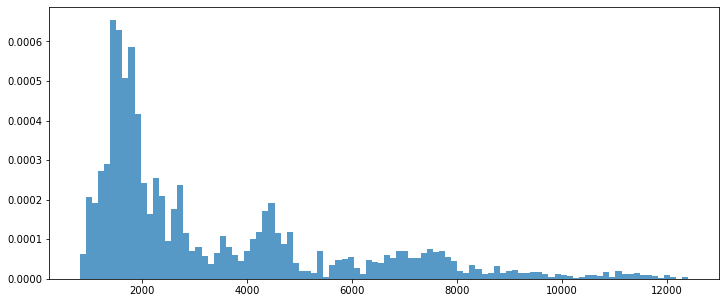

In [53]:
_ = plt.hist(df.Close, 100, density=True, alpha=0.75)

- z-test

In [54]:
from statsmodels.stats.weightstats import ztest
_, p = ztest(df.Close)
print(p)

0.0


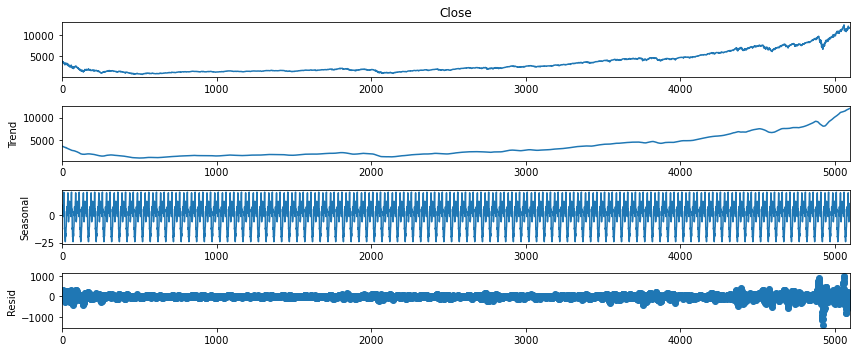

In [55]:
result = seasonal_decompose(df.Close, model='additive', two_sided=True, period=50, extrapolate_trend='freq')
result.plot()
plt.show()

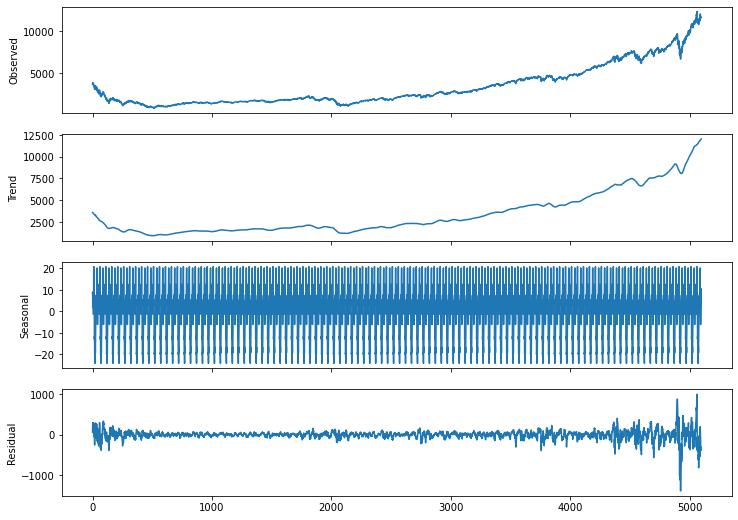

In [56]:
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

<AxesSubplot:>

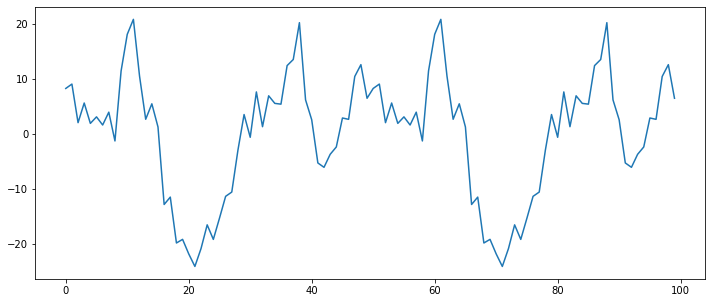

In [57]:
result.seasonal[:100].plot()

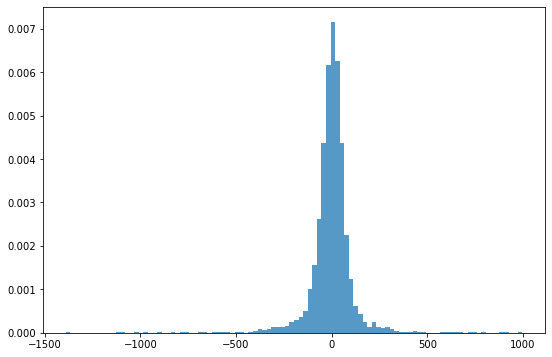

In [58]:
fig, ax = plt.subplots(figsize=(9, 6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

In [59]:
r = result.resid.values
st, p = ztest(r)
print(st, p)

-0.8390076883668717 0.4014649952251901


In [60]:
mu, std = result.resid.mean(), result.resid.std()
print('평균:', mu, '표준편차:', std)

print('이상치 갯수:', len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))

평균: -1.2913972051413372 표준편차: 109.8990193543672
이상치 갯수: 92


In [61]:
ls = list(df.Date[result.resid[
    (result.resid>mu+3*std)|(result.resid<mu-3*std)].index])

In [62]:
print(ls)

[Timestamp('2000-12-20 00:00:00'), Timestamp('2001-01-02 00:00:00'), Timestamp('2001-01-29 00:00:00'), Timestamp('2001-01-30 00:00:00'), Timestamp('2001-04-03 00:00:00'), Timestamp('2001-04-04 00:00:00'), Timestamp('2015-08-24 00:00:00'), Timestamp('2015-08-25 00:00:00'), Timestamp('2018-02-08 00:00:00'), Timestamp('2018-02-09 00:00:00'), Timestamp('2018-03-09 00:00:00'), Timestamp('2018-03-12 00:00:00'), Timestamp('2018-04-02 00:00:00'), Timestamp('2018-10-29 00:00:00'), Timestamp('2018-12-03 00:00:00'), Timestamp('2018-12-21 00:00:00'), Timestamp('2018-12-26 00:00:00'), Timestamp('2018-12-28 00:00:00'), Timestamp('2019-01-03 00:00:00'), Timestamp('2019-05-29 00:00:00'), Timestamp('2019-05-31 00:00:00'), Timestamp('2019-06-03 00:00:00'), Timestamp('2019-06-04 00:00:00'), Timestamp('2019-06-05 00:00:00'), Timestamp('2019-08-05 00:00:00'), Timestamp('2020-02-10 00:00:00'), Timestamp('2020-02-11 00:00:00'), Timestamp('2020-02-12 00:00:00'), Timestamp('2020-02-13 00:00:00'), Timestamp('20

- 2000년, 2018년, 2020년등의 미국 증시는 기존의 흐림과는 달리 폭락, 폭등 등 정시의 변동성이 컸었고 이 기간의 값들은 기존의 증시 흐름에 대비하여 특이치로 보여진다. 
- 이러한 이상치는 주식에 대한 이해를 가지고 있다면 충분히 가능한 일이며 따라서 이를 교정하는 경우 오히려 실제 데이터를 조작하는 것이 되어 적절하지 않을 것으로 판단된다. 

#### 3. Unsupervised Clustering으로 이상치 찾기 
##### 3-1 K-means로 분석하기

In [63]:
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    for f in features:
        result = seasonal_decompose(df[f], model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

tdf, sdf, rdf = my_decompose(df, features=['Open', 'High', 'Low', 'Close', 'Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,5098.000000,5098.000000,5098.000000,5098.000000,5098.000000
mean,3330.724999,3362.220146,3298.532406,3332.609090,288057.188854
std,2400.892883,2422.863050,2379.665832,2404.825139,109834.091507
min,914.415000,934.695000,895.770000,915.335000,64880.520000
25%,1584.407500,1597.671250,1571.153750,1584.352001,220586.700000
50%,2264.797500,2292.105000,2232.207500,2265.174199,268932.110000
75%,4434.168125,4466.316875,4401.132500,4435.347500,319674.830000
max,12039.860297,12201.437499,11870.369861,12047.090432,776809.340000


In [64]:
rdf.describe()

,Open,High,Low,Close,Volume
count,5098.000000,5098.000000,5098.000000,5098.000000,5098.000000
mean,-1.361168,-1.421971,-1.241082,-1.314223,155.136515
std,112.249407,102.051145,116.463672,110.054996,110706.241180
min,-1280.580676,-1494.706438,-1226.976539,-1390.196689,-602731.340129
25%,-38.117788,-35.393102,-38.318769,-37.788724,-53311.671523
50%,3.476876,3.331959,4.089242,2.923191,-488.997470
75%,40.164011,37.638459,41.675332,40.863314,51480.694345
max,996.954616,933.609579,944.823580,996.320780,810713.135421


In [65]:
scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[ -1.36116811  -1.42197139  -1.24108161  -1.31422283 155.13651478]


array([[ 0.94892246,  0.84646493,  0.81728626,  0.60184276,  0.08322602],
       [ 0.49026957,  1.28420778,  1.38842808,  2.09551792,  0.10454779],
       [ 1.90750707,  2.01838985,  2.0481367 ,  2.7378712 , -0.08888583],
       ...,
       [-2.9355638 , -3.75950684, -2.18973446, -2.93558305,  0.44805172],
       [-3.02900188, -4.45234664, -3.01260131, -3.46542972,  0.39484453],
       [-3.32615554, -5.03188414, -2.82731937, -3.56760069,  0.48127544]])

In [66]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_)

[1 1 1 ... 0 0 0]


In [67]:
lbl, cnt = np.unique(kmeans.labels_, return_counts=True)
print(lbl)
print(cnt)

[0 1]
[1099 3999]


In [68]:
kmeans=KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_, return_counts=True)
[f'group : {group} - count : {count}' for group, count in zip(lbl, cnt)]

['group : 0 - count : 1008',
 'group : 1 - count : 66',
 'group : 2 - count : 1097',
 'group : 3 - count : 18',
 'group : 4 - count : 296',
 'group : 5 - count : 495',
 'group : 6 - count : 459',
 'group : 7 - count : 33',
 'group : 8 - count : 19',
 'group : 9 - count : 831',
 'group : 10 - count : 331',
 'group : 11 - count : 98',
 'group : 12 - count : 11',
 'group : 13 - count : 98',
 'group : 14 - count : 238']

In [69]:
df[(kmeans.labels_==3)|(kmeans.labels_==8)| (kmeans.labels_==12)]

,Date,Open,High,Low,Close,Adj Close,Volume
4362,2018-01-24,6956.500000,7004.250000,6888.250000,6931.250000,6931.250000,526387.0
4399,2018-03-19,7043.000000,7043.000000,6821.250000,6914.250000,6914.250000,571979.0
4537,2018-10-04,7651.000000,7651.000000,7456.500000,7514.250000,7514.250000,704908.0
4578,2018-12-04,7055.250000,7055.250000,6783.000000,6803.250000,6803.250000,811925.0
4680,2019-05-06,7810.000000,7817.500000,7667.500000,7803.500000,7803.500000,630196.0
4681,2019-05-07,7744.750000,7804.000000,7581.250000,7674.000000,7674.000000,838952.0
4891,2020-02-11,9525.000000,9609.500000,9501.250000,9527.250000,9527.250000,589570.0
4892,2020-02-12,9536.250000,9628.250000,9523.750000,9625.750000,9625.750000,454472.0
4893,2020-02-13,9621.500000,9644.750000,9511.250000,9613.000000,9613.000000,613580.0
4894,2020-02-14,9626.250000,9659.250000,9588.000000,9632.250000,9632.250000,489387.0


In [70]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5098.000000,5098.000000,5098.000000,5098.000000,5098.000000,5.098000e+03
mean,3329.358747,3360.794284,3297.286767,3331.291122,3331.291122,2.882167e+05
std,2400.978546,2422.128357,2380.456260,2404.769584,2404.769584,1.595897e+05
min,810.000000,828.500000,797.500000,809.500000,809.500000,0.000000e+00
25%,1593.500000,1608.500000,1576.500000,1593.125000,1593.125000,1.907512e+05
50%,2232.000000,2259.875000,2211.750000,2232.875000,2232.875000,2.657315e+05
75%,4447.000000,4469.875000,4419.437500,4451.187500,4451.187500,3.562115e+05
max,12408.500000,12465.200195,12172.200195,12411.500000,12411.500000,1.580041e+06


In [71]:
pd.DataFrame(kmeans.cluster_centers_, columns=['Open', 'High', 'Low', 'Close', 'Volume'])

,Open,High,Low,Close,Volume
0,0.194578,0.193084,0.252013,0.233630,-0.443905
1,-1.333821,-1.483672,-2.026410,-2.027606,3.052986
2,-0.234961,-0.237032,-0.220148,-0.218888,0.175160
3,2.867673,2.755949,2.001638,1.941786,2.835088
4,-0.019224,-0.041160,-0.306351,-0.279899,1.701011
5,0.868996,0.903342,0.935606,0.923896,-0.310361
6,-0.899405,-0.912158,-0.888788,-0.866056,0.467757
7,-4.195611,-4.554132,-4.181233,-4.167360,0.790436
8,6.092861,6.187818,6.208749,6.171515,-0.432828
9,0.316971,0.346216,0.271677,0.288842,0.449370


- 위의 결과들 또한 2000년, 2018년, 2020년이 나오고 이 해의 기사를 검색하여 보면 공포, 폭락 등 기존과는 다른 증시의 모습을 볼 수 있다. 
- 이러한 이상치 값은 특이치이며 그대로 사용하여야 한다. 

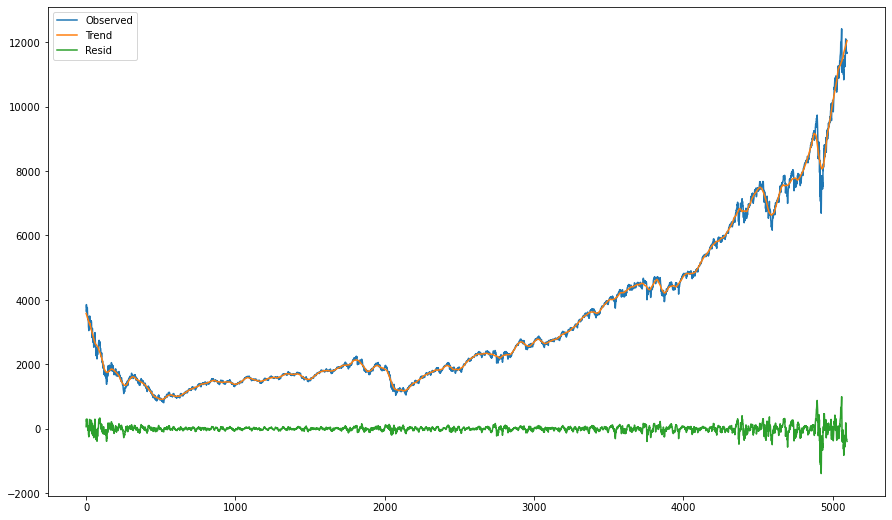

In [72]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Close.plot(ax=ax, label='Observed', legend=True)
tdf.Close.plot(ax=ax, label='Trend', legend=True)
rdf.Close.plot(ax=ax, label='Resid', legend=True)
plt.show()


- 위의 그래프에서 증시의 변화가 심한 경우에 Residual 값이 큰 범위로 변화는 것을 확인할 수 있다.

##### 3-2  DBSCAN으로 분석하기

In [73]:
clustering = DBSCAN(eps=0.7, min_samples=2).fit(norm_rdf)
clustering

DBSCAN(eps=0.7, min_samples=2)

In [74]:
print(clustering.labels_)

[ 0  0  0 ... 24 25 25]


In [75]:
lbl, cnt = np.unique(clustering.labels_, return_counts=True)
[f'group : {group} - count : {count}' for group, count in zip(lbl, cnt)]

['group : -1 - count : 197',
 'group : 0 - count : 4839',
 'group : 1 - count : 2',
 'group : 2 - count : 2',
 'group : 3 - count : 12',
 'group : 4 - count : 2',
 'group : 5 - count : 2',
 'group : 6 - count : 2',
 'group : 7 - count : 2',
 'group : 8 - count : 3',
 'group : 9 - count : 2',
 'group : 10 - count : 2',
 'group : 11 - count : 2',
 'group : 12 - count : 2',
 'group : 13 - count : 2',
 'group : 14 - count : 2',
 'group : 15 - count : 2',
 'group : 16 - count : 2',
 'group : 17 - count : 2',
 'group : 18 - count : 2',
 'group : 19 - count : 2',
 'group : 20 - count : 2',
 'group : 21 - count : 3',
 'group : 22 - count : 2',
 'group : 23 - count : 2',
 'group : 24 - count : 2',
 'group : 25 - count : 2']

#### 4. LSTM 오토인코더로 이상치 찾기

In [76]:
tf.random.set_seed(777)
np.random.seed(777)

In [77]:
window_size = 10
batch_size = 32
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE, features].values)
scaled = scaler.transform(df[features].values)

In [78]:
train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


In [79]:
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    
    RepeatVector(window_size),
    
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10, 64)            17920     
_________________________________________________________________
lstm_7 (LSTM)                (None, 16)                5184      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 16)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 46,277
Trainable params: 46,277
Non-trainable params: 0
__________________________________________________

In [80]:
checkpoint_path = os.getenv('HOME')+'/Aiffel/20_anomaly_detection/nadaq/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])

In [81]:
hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

Epoch 1/50
157/159 [============================>.] - ETA: 0s - loss: 1.9653 - mae: 1.9653
Epoch 00001: val_loss improved from inf to 2.32304, saving model to /home/aiffel/Aiffel/20_anomaly_detection/nadaq/mymodel.ckpt
159/159 [==============================] - 4s 28ms/step - loss: 1.9429 - mae: 1.9429 - val_loss: 2.3230 - val_mae: 2.3230
Epoch 2/50
159/159 [==============================] - ETA: 0s - loss: 0.5680 - mae: 0.5680
Epoch 00002: val_loss improved from 2.32304 to 1.39592, saving model to /home/aiffel/Aiffel/20_anomaly_detection/nadaq/mymodel.ckpt
159/159 [==============================] - 4s 28ms/step - loss: 0.5680 - mae: 0.5680 - val_loss: 1.3959 - val_mae: 1.3959
Epoch 3/50
157/159 [============================>.] - ETA: 0s - loss: 0.4385 - mae: 0.4385
Epoch 00003: val_loss improved from 1.39592 to 0.41061, saving model to /home/aiffel/Aiffel/20_anomaly_detection/nadaq/mymodel.ckpt
159/159 [==============================] - 4s 26ms/step - loss: 0.4372 - mae: 0.4372 - val_

In [82]:
model.load_weights(checkpoint_path)

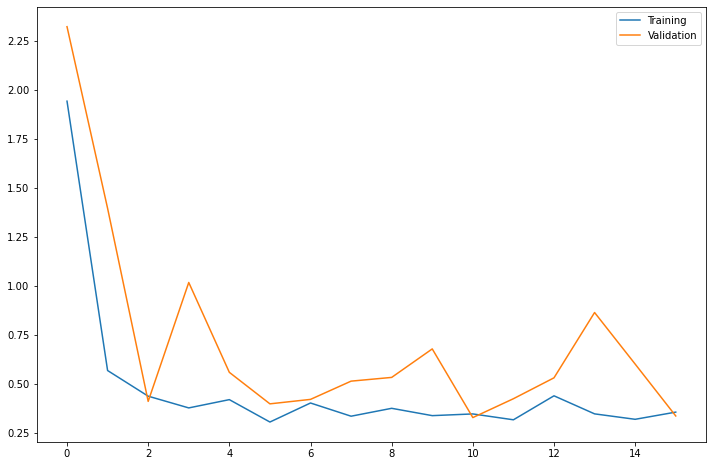

In [83]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

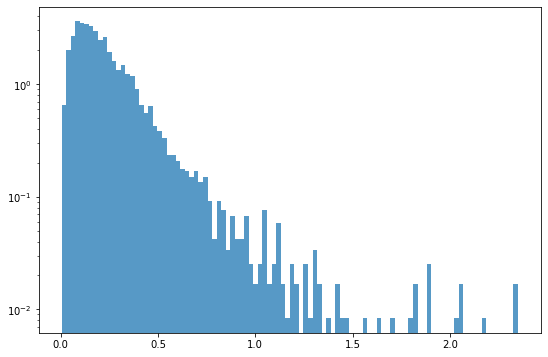

In [84]:
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [85]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 1.5
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
4532,2018-10-11,7010.25,7138.00,6907.75,7031.000000,7031.000000,1146270.0,1.828746
4891,2020-02-24,9355.25,9365.00,9041.25,9091.000000,9091.000000,1171879.0,1.714572
4892,2020-02-25,9091.00,9224.25,8810.00,8854.250000,8854.250000,1344897.0,2.066322
4893,2020-02-26,8868.25,9037.50,8709.50,8850.250000,8850.250000,1251412.0,1.806817
4894,2020-02-27,8811.50,8878.50,8334.25,8382.750000,8382.750000,1580041.0,2.333755
4895,2020-02-28,8347.00,8574.75,8126.25,8454.000000,8454.000000,1527204.0,2.169900
4896,2020-03-01,8347.00,8574.75,8126.25,8382.750000,8382.750000,1513887.0,1.893534
4897,2020-03-02,8349.25,8883.25,8224.25,8791.250000,8791.250000,1373357.0,2.052042
4898,2020-03-03,8830.50,9002.50,8511.00,8582.500000,8582.500000,1295648.0,2.350075
4899,2020-03-04,8557.50,8950.00,8508.25,8896.500000,8896.500000,939032.0,1.893322


**threshold를 1.5로 주었을 때는 주식 시장이 폭락한 경우값이 이상치로 분류되었다**

In [86]:
threshold = 1.0
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
1747,2007-08-16,1877.500000,1878.750000,1813.750000,1856.500000,1856.500000,982573.0,1.189372
1806,2007-11-08,2175.000000,2180.000000,2081.000000,2105.500000,2105.500000,884081.0,1.046477
1854,2008-01-23,1809.500000,1812.000000,1698.250000,1807.500000,1807.500000,888037.0,1.024503
2035,2008-10-10,1281.750000,1326.250000,1198.250000,1282.500000,1282.500000,829115.0,1.116558
3534,2014-10-15,3823.750000,3831.500000,3691.250000,3752.000000,3752.000000,831107.0,1.112031
...,...,...,...,...,...,...,...,...
5054,2020-09-08,11531.000000,11585.000000,11040.500000,11060.500000,11060.500000,1012392.0,1.420563
5063,2020-09-21,10920.000000,11009.799805,10656.500000,10989.000000,10989.000000,727984.0,1.108189
5066,2020-09-24,10803.500000,11011.799805,10660.200195,10891.799805,10891.799805,791934.0,1.036747
5078,2020-10-12,11722.799805,12197.000000,11687.799805,12098.200195,12098.200195,756438.0,1.124222


**threshold를 1.0으로 변경하여 주니 급등을 하는 시기도 분류가 되었다.**

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


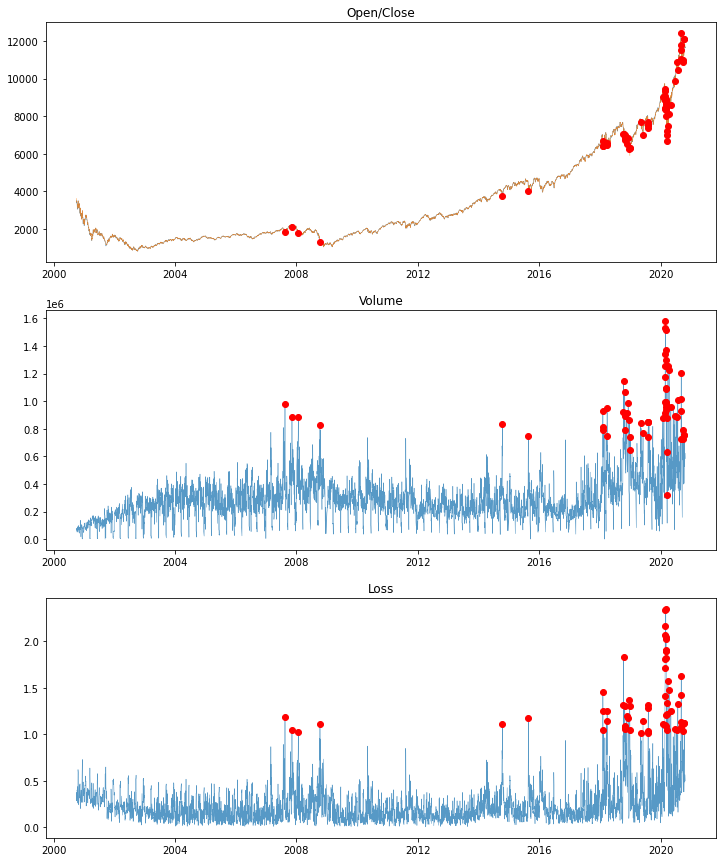

In [87]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])

In [ ]:
- LSTM 오토인코더를 사용하는 경우에는 threshold를 얼마로 하냐에 따라서 기존의 통계적인 방식으로 찾은 이상값과 같은 경우도 

#### 5. 고찰 
- 이전까지는 데이터를 직접확인하여 극단치값을 제거하여 주는 작업만 수행하였는데 이번 프로젝트를 통해 이상치값이 극단치인지 그리고 특이치인지에 따라 수행해야 하는 방법이 다르다는 것을 알게되었고 또한 이상치를 찾는 다양한 방법과 도메인 지식의 중요성을 알 수 있는 프로젝트였다. 